# Imbalanced Classification: Oil Spill Classification

### Main techniques used:
* Scaling
* Normalization
* Data Sampling - SMOTE+ENN
* Probability Threshold Moving

### Background:
* The Oil Spill Classification dataset is an example of an imbalanced classification problem where a class label is required, and both positive and negative classes are equally important. (Detecting and acting on a spill is an expensive response, so false positives are bad. However it is also equally expensive and bad to miss an oil spill event.)
* The G-mean provides a way to evaluate imbalanced classification model in such a situation where Sensitivity and Specificity are both important metrics.
* In this project, we will utilize various Probability Threshold Moving techniques to further improve classification metrics performance.

In [1]:
# Import necessary libraries

from matplotlib import pyplot
from collections import Counter

from numpy import mean
from numpy import std
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from imblearn.metrics import geometric_mean_score
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

from sklearn.dummy import DummyClassifier

from numpy import sqrt
from numpy import argmax
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

### Simple EDA of the data

(937, 50)
Class = 1.0, Count = 41, Percentage = 4.376%
Class = 0.0, Count = 896, Percentage = 95.624%


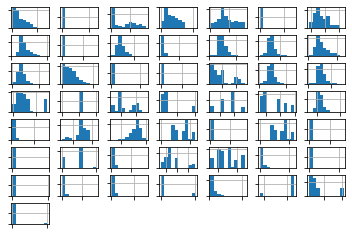

In [2]:
filename = 'oil-spill.csv'
dataframe = read_csv(filename, header=None)
print(dataframe.shape)

target = dataframe.values[:,-1]
counter = Counter(target)
for k, v in counter.items():
    per = v / len(target) * 100
    print(f"Class = {k}, Count = {v}, Percentage = {per:.3f}%")
    
ax = dataframe.hist()
for axis in ax.flatten():
    axis.set_title('')
    axis.set_xticklabels([])
    axis.set_yticklabels([])
pyplot.show()

**Note:** We can see that the target class distribution is quite imbalanced.

**Note:** We can also see that there are many different distributions, and we expect that scaling and using power transforms may be useful, before proceeding to modelling.

### Evaluate a Baseline Model for reference

In [3]:
# Define a few custom functions

def load_dataset(full_path):
    # load the dataset as a numpy array
    data = read_csv(full_path, header=None)
    # drop unused columns
    data.drop(22, axis=1, inplace=True)
    data.drop(0, axis=1, inplace=True)
    # retrieve numpy array
    data = data.values
    # split into input and output elements
    X, y = data[:, :-1], data[:, -1]
    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    return X, y

# Evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define the model evaluation the metric
    metric = make_scorer(geometric_mean_score)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

In [4]:
# define the location of the dataset
full_path = 'oil-spill.csv'

# load the dataset
X, y = load_dataset(full_path)

# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))

# define the reference model
model = DummyClassifier(strategy='uniform')

# evaluate the model
scores = evaluate_model(X, y, model)

# summarize performance
# print('Mean G-Mean: %.3f (%.3f)' % (mean(scores), std(scores)))
print(f"Mean G-Mean: {mean(scores):.3f} ({std(scores):.3f}%)")

(937, 47) (937,) Counter({0: 896, 1: 41})
Mean G-Mean: 0.497 (0.140%)


**Note:** Remember that Sensitivity is a measure of accuracy for the positive class, and Specificity is a measure of accuracy for the negative class. 

**Note:** G-mean seeks a balance of the sensitivity score + the specificity score. Poor performance for either will be penalized.

**Note:** We can see that the baseline algorithm achieves a G-mean of about 0.50. This score provides us with a lower limit on model skill. Any model that achieves an average G-mean of above 0.50 has skill, whereas models that achieve a score below this value do not have skill on this dataset.

### Modelling

**Note:** In another project utilizing the same oil-spill dataset, we have shown that it is possible to attain good results by performing:
* Normalization, Power Transforms, SMOTEENN (data sampling technique) prior to training a classifier.
* After this, we will go on to evaluate various probability threshold moving techniques.

In [12]:
# Prepare the dataset here for modelling
full_path = 'oil-spill.csv'
X, y = load_dataset(full_path)

trainX, testX, trainy, testy = train_test_split(X, y, test_size = 0.3, random_state=88,
                                               stratify=y)


In [13]:
# Pg 254

# Define the model here
sampling = SMOTEENN(enn = EditedNearestNeighbours(sampling_strategy='majority'))
model = LogisticRegression(solver='liblinear')
steps = [('t1', MinMaxScaler()), ('t2', PowerTransformer()), ('e', sampling), ('m', model)]
pipeline = Pipeline(steps=steps)
pipeline.fit(trainX, trainy)

Pipeline(steps=[('t1', MinMaxScaler()), ('t2', PowerTransformer()),
                ('e',
                 SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))),
                ('m', LogisticRegression(solver='liblinear'))])

In [27]:
# Predicted probabilities here
yhat = pipeline.predict_proba(testX)

# Predicted classes here (based on default threshold of 0.5 for classification)
y_pred_class = pipeline.predict(testX)

# Keep probabilities for the positive outcome only
yhat = yhat[:, 1]

#### Optimal Threshold:
* **ROC Curves**
* Optimal balance between false positives and true positives rates
* **Largest G-mean value**

In [31]:
print(f"Default Threshold = 0.5, G-mean Score: {geometric_mean_score(testy, y_pred_class):.4f}")

Default Threshold = 0.5, G-mean Score: 0.7261


In [32]:
# Calculate ROC Curves
fpr, tpr, thresholds = roc_curve(testy, yhat)

gmeans = sqrt(tpr * (1-fpr))

# Get best threshold
J = tpr - fpr
ix = argmax(J)
best_threshold = thresholds[ix]
print(f"Best Threshold = {best_threshold}, G-mean Score = {gmeans[ix]:.4f}")

Best Threshold = 0.21772909351824177, G-mean Score = 0.9189


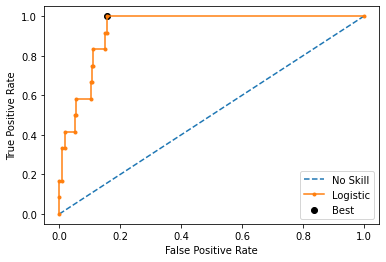

In [20]:
# Visualize the above results

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

**Note:**
* Using the default threshold of 0.5, the G-mean score was 0.7261.
* Using the Best Threshold found of 0.2177, the G-mean score was 0.9189.
* We can also see this point on the above ROC curve.
* We can see that it is possible to further fine-tune the threshold for classification, resulting in better performance based on the chosen evaluation metric that makes business sense.

#### Optimal Threshold:
* **Precision-Recall Curves**
* Focuses on the performance of a classifier on the positive (minority class) only
* If interested in the optimal balance of precision and recall
* **Largest F-measure value**

Best Threshold=0.977484, F-measure=0.455


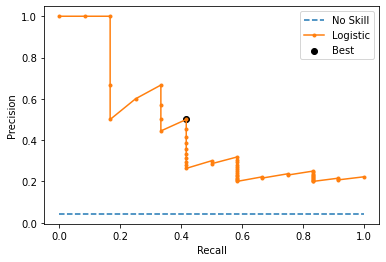

In [21]:
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# convert to f-measure
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f-measure
ix = argmax(fscore)
print('Best Threshold=%f, F-measure=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()
